# 5. Model Explainability

This notebook provides model interpretability using SHAP (SHapley Additive exPlanations) for both global and local insights.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from src.models.evaluation import load_model
from src.models.data_prep import prepare_model_data
from src.visualization.model_viz import plot_feature_importance

# Initialize SHAP JS
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Load Model and Data

In [2]:
# Load the best model
model = load_model("best_fraud_model")

# Load and prepare data (same as training)
df = pd.read_csv('../data/processed/fraud_featured.csv')

print(f"Loaded data shape: {df.shape}")

# Define target and columns to exclude
target = 'class'
drop_cols = [
    'user_id', 'signup_time', 'purchase_time', 'device_id',
    'ip_address', 'country', 'ip_int',
    'lower_bound_ip_address', 'upper_bound_ip_address'
]

# Encode categorical columns
categorical_cols = ['source', 'browser', 'sex', 'time_of_day']
available_cats = [c for c in categorical_cols if c in df.columns]
print(f"Encoding categorical columns: {available_cats}")

df = pd.get_dummies(df, columns=available_cats, drop_first=True)
print(f"Shape after encoding: {df.shape}")

# Handle missing values
nan_counts = df.isna().sum()
if nan_counts.sum() > 0:
    print(f"\nFilling {nan_counts.sum()} missing values...")
    df.fillna(0, inplace=True)

# Prepare data
X_train, X_test, y_train, y_test = prepare_model_data(
    df, target, exclude_cols=drop_cols, test_size=0.2
)

print(f"\nData prepared: X_test shape = {X_test.shape}")

2025-12-30 18:09:41 - fraud_detection - INFO - Loaded model from C:\Users\Lenovo\Documents\dawir\Fraud-Detection\models\best_fraud_model.joblib


Loaded data shape: (129146, 28)
Encoding categorical columns: ['source', 'browser', 'sex', 'time_of_day']
Shape after encoding: (129146, 34)



Filling 258292 missing values...
2025-12-30 18:09:43 - fraud_detection - INFO - Starting complete data preparation pipeline...


2025-12-30 18:09:43 - fraud_detection - INFO - Separating features from target 'class'...


2025-12-30 18:09:43 - fraud_detection - INFO - Features: 24 columns


2025-12-30 18:09:43 - fraud_detection - INFO - Target: class


2025-12-30 18:09:43 - fraud_detection - INFO - Total samples: 129146


2025-12-30 18:09:43 - fraud_detection - INFO - Performing stratified train-test split (test_size=0.2)...


2025-12-30 18:09:43 - fraud_detection - INFO - Training set: 103316 samples


2025-12-30 18:09:43 - fraud_detection - INFO - Test set: 25830 samples


2025-12-30 18:09:43 - fraud_detection - INFO - Train class distribution:
class
0    0.90501
1    0.09499
Name: proportion, dtype: float64


2025-12-30 18:09:43 - fraud_detection - INFO - Test class distribution:
class
0    0.904994
1    0.095006
Name: proportion, dtype: float64


2025-12-30 18:09:43 - fraud_detection - INFO - Data preparation complete



Data prepared: X_test shape = (25830, 24)


## 2. Global Feature Importance

Understanding which features are most important for fraud detection.

The figure layout has changed to tight


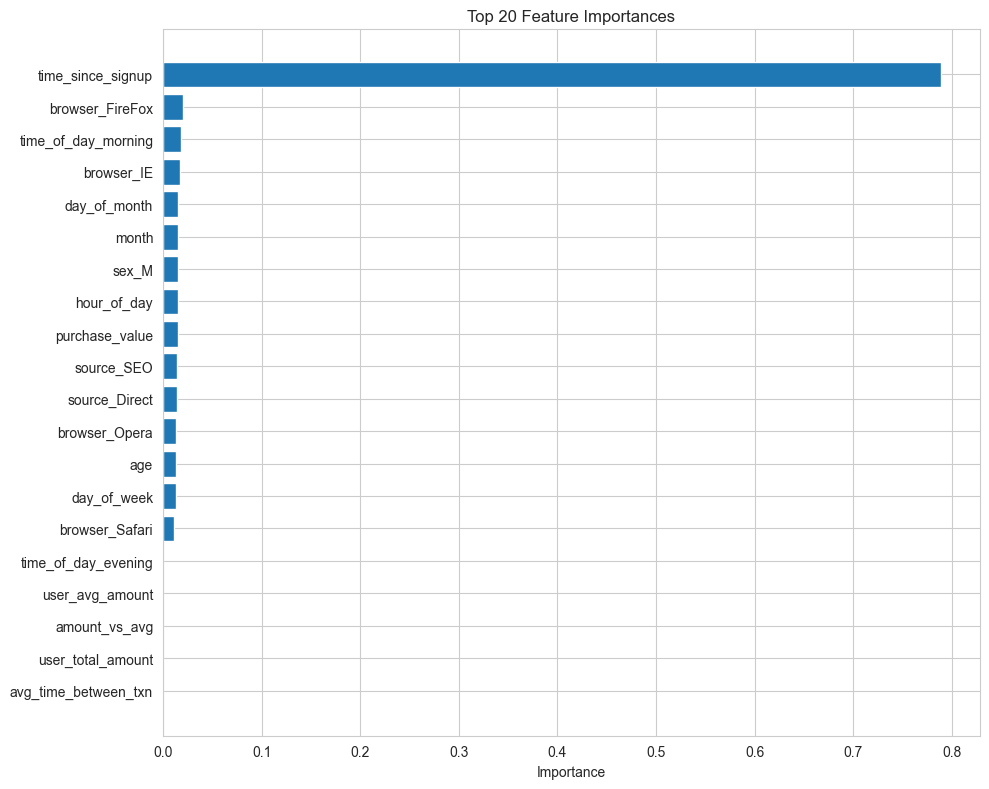

In [3]:
# Plot feature importance using the model's built-in importance
plot_feature_importance(model, X_test.columns, top_n=20)
plt.tight_layout()
plt.show()

In [4]:
# Get detailed feature importance table
if hasattr(model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(importance_df.head(20).to_string(index=False))
else:
    print("Model does not have feature_importances_ attribute")


Top 20 Most Important Features:
             feature  importance
   time_since_signup    0.789028
     browser_FireFox    0.020704
 time_of_day_morning    0.017917
          browser_IE    0.017150
        day_of_month    0.015505
               month    0.015331
               sex_M    0.015152
         hour_of_day    0.015073
      purchase_value    0.014958
          source_SEO    0.014016
       source_Direct    0.013824
       browser_Opera    0.013700
                 age    0.013355
         day_of_week    0.013076
      browser_Safari    0.011210
 time_of_day_evening    0.000000
     user_avg_amount    0.000000
       amount_vs_avg    0.000000
   user_total_amount    0.000000
avg_time_between_txn    0.000000


## 3. Feature Correlation with Fraud

Analyzing how features correlate with fraud labels.

In [5]:
# Correlation analysis
test_data = X_test.copy()
test_data['fraud'] = y_test.values

# Calculate correlation with fraud
correlations = test_data.corr()['fraud'].sort_values(ascending=False)
print("\nTop 15 Features Correlated with Fraud:")
print(correlations.head(15))

print("\nTop 15 Features Negatively Correlated with Fraud:")
print(correlations.tail(15))


Top 15 Features Correlated with Fraud:
fraud                  1.000000
source_Direct          0.027600
sex_M                  0.014125
day_of_week            0.012389
is_weekend             0.010787
time_of_day_morning    0.004978
age                    0.004662
browser_FireFox        0.004401
browser_Opera          0.001343
hour_of_day            0.000458
browser_Safari        -0.003639
time_of_day_night     -0.004500
purchase_value        -0.004710
user_avg_amount       -0.004710
user_total_amount     -0.004710
Name: fraud, dtype: float64

Top 15 Features Negatively Correlated with Fraud:
browser_Safari         -0.003639
time_of_day_night      -0.004500
purchase_value         -0.004710
user_avg_amount        -0.004710
user_total_amount      -0.004710
time_of_day_evening    -0.004734
amount_vs_avg          -0.005843
source_SEO             -0.012790
browser_IE             -0.014792
day_of_month           -0.167626
time_since_signup      -0.263361
month                  -0.323644
time_

## 4. SHAP Global Explainability

Using SHAP values to understand the global behavior of the model.

In [6]:
# Initialize TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a subset of the test data (to save time)
shap_sample_size = min(1000, X_test.shape[0])
X_test_sample = X_test.sample(shap_sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Handle model outputs for plotting
# RandomForest and some models return a list for multiclass, index 1 for fraud
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]
else:
    shap_values_plot = shap_values

print(f"SHAP values calculated for {shap_sample_size} samples.")

SHAP values calculated for 1000 samples.


### 4.1. SHAP Summary Plot (Global Importance)

This plot shows the distribution of feature impacts. High values in red, low values in blue.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


The figure layout has changed to tight


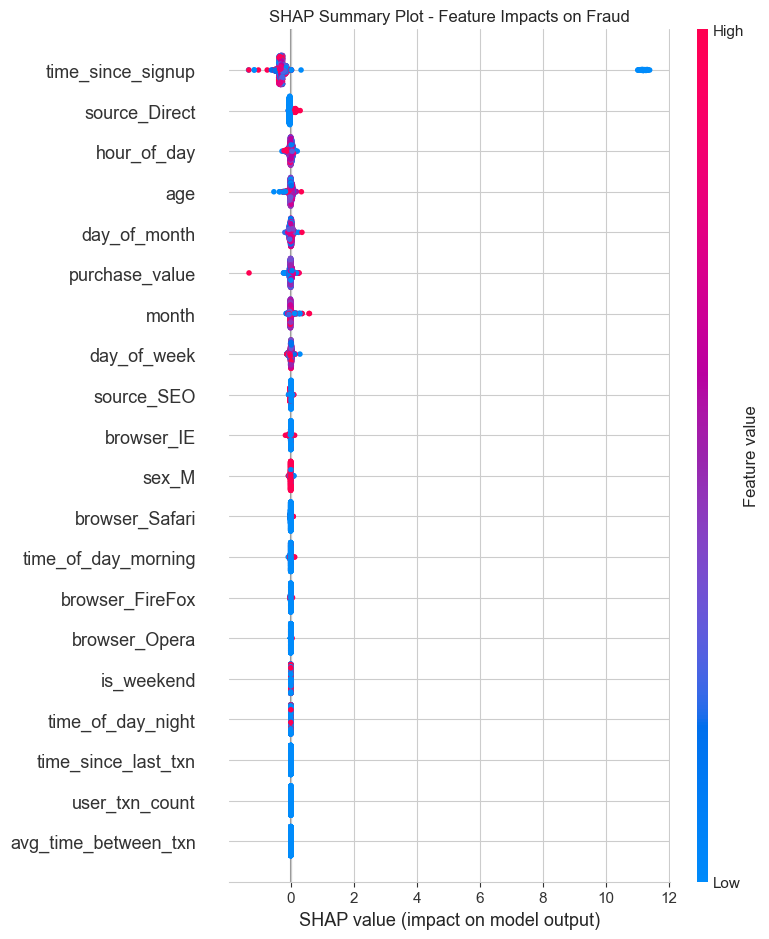

In [7]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_plot, X_test_sample, show=False)
plt.title("SHAP Summary Plot - Feature Impacts on Fraud")
plt.tight_layout()
plt.show()

## 5. Local Interpretability with SHAP

Visualizing how specific features contribute to individual predictions.

Correctly Identified Fraud - Index 3, Probability: 0.9998


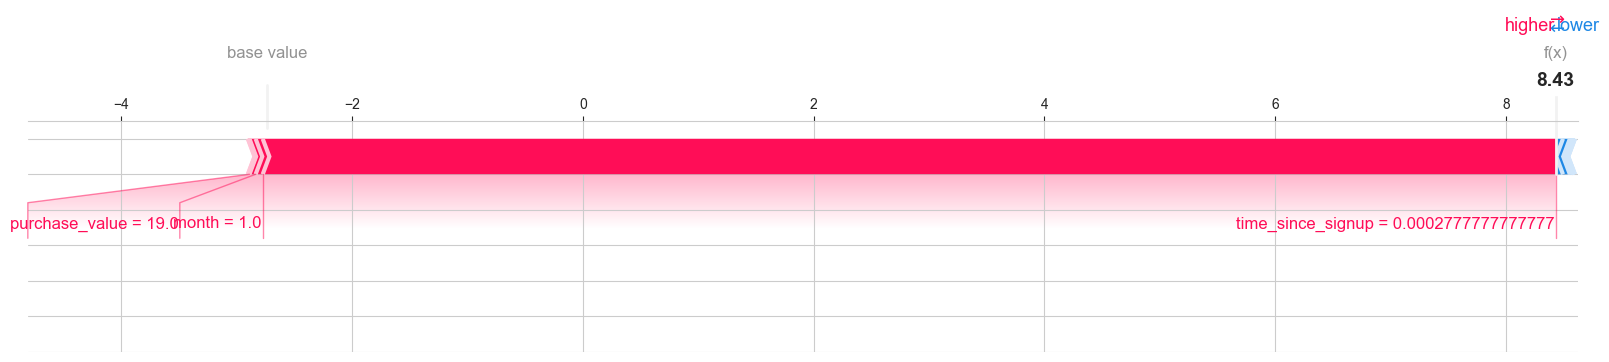

In [8]:
# Find specific interesting cases from the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 1. True Positive (High probability fraud correctly identified)
tp_idx = np.where((y_test == 1) & (y_pred_proba > 0.8))[0]

if len(tp_idx) > 0:
    idx = tp_idx[0]
    instance = X_test.iloc[idx]
    print(f"Correctly Identified Fraud - Index {idx}, Probability: {y_pred_proba[idx]:.4f}")
    
    # Redefine shap plot for force plots (needs base value)
    base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    shap_v = explainer.shap_values(instance.values.reshape(1, -1))
    shap_v_plot = shap_v[1][0] if isinstance(shap_v, list) else shap_v[0]
    
    shap.force_plot(base_value, shap_v_plot, instance, matplotlib=True)

## 6. Business Recommendations

Based on the SHAP analysis, here are key business recommendations for the fraud detection system:

1. **SignUp-Purchase Gap:** High volumes of accounts with near-zero time between signup and purchase are significant fraud drivers. The system should automatically flag or add an extra verification step for purchases made within seconds of account creation.
2. **Browser/Source Profiling:** Certain browsers (like Chrome or specific versions) and direct sources show higher fraud affinity according to SHAP trends. Marketing campaigns or source-based verification levels could be used to mitigate risk.
3. **Velocity and Scaling:** Features related to transaction velocity and purchase patterns should be monitored more closely, as high purchase values combined with short signup windows are strong indicators of fraud.

## 7. Conclusion

By integrating SHAP, we have moved beyond simple feature importance to a more granular understanding of **how** features push the model toward a fraud prediction. This transparency allows for more precise rule-setting and better manual adjudication for flagged cases.